In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import PyIF
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from sklearn import metrics
from scipy import stats, spatial
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from matplotlib import gridspec, cm, animation
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import warnings
warnings.filterwarnings('ignore')

ee.Initialize()

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# Info Theory math


#### Entropy (Shannon, 1948): 

Given a discrete random variable $X$, with possible outcomes $ x_{1},...,x_{n} $ which occur with probability $  \mathrm {P} (x_{1}),...,\mathrm {P} (x_{n}) $ the entropy (units of nats) of $X$ is defined as: <br>

$ H(X) =  - \sum_{i=1}^{n} P(x) \ln P(x) $

#### Joint Entropy:
of two discrete random variables $X$ and $Y$ is defined as the entropy of the joint distribution of $X$ and $Y$:

$ H(X,Y) =  - \sum_{i=1}^{n} P(x,y) \ln P(x,y) $


#### Conditional Entropy: 

The amount of information needed to describe the outcome of a random variable $Y$ given that the value of another random variable $X$ is known. Here, information is measured in shannons, nats, or hartleys. The entropy of $Y$ conditioned on $X$ is:

$ H (Y|X) = -\sum p(x,y)\ln {\frac {p(x,y)}{p(x)}} $


#### Relative Entropy, aka K-L Divergence,

The Relative Entropy (aka K-L divergence, $ D_{\text{KL}}(P\parallel Q)$ ), which measures how one probability distribution $P(x)$ is different from a second $Q(x)$ is defined as:

$ D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\ln \left({\frac {P(x)}{Q(x)}}\right)$

#### Jensen Shannon Distance:

The Jensen Shannon Distance (JSD) also measures how one probability distribution $P(x)$ is different from a second $Q(x)$, but has desirable properties of always being finite and symmetric: 

$ JSD(X) = \sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}\$

where $D(x \parallel y)$ is the K-L Divergence, defined above.


#### Mutual information

measures how much information can be obtained about one random variable by observing another. The mutual information of $X$ relative to $Y$ (which represents conceptually the average amount of information about $X$ that can be gained by observing $Y$ is given by:

$ I(X; Y)=H(X)− H(X|Y)= -\sum p(x,y)\ln \frac{p(x,y)}{p(x) p(y)} $

#### Transfer entropy (Schreiber, 2000)

is the amount of directed (time-asymmetric) transfer of information between two random processes. Transfer entropy from a process X to another process Y is the amount of uncertainty reduced in future values of Y by knowing the past values of X given past values of Y.

$ T_{X→Y} = \sum p(y_{t+1}, y_{t}, x_{t}) ln( \frac{p(y_{t+1} | y_{t} , x_{t})} {p(y_{t+1} | y_{t})}) $

Can be thought of as the deviation from independence
(in bits) of the state transition (from the previous state
to the next state) of an information destination X from
the (previous) state of an information source Y

Transfer entropy can be thought of as Conditional mutual Information (Lizier, 2008): 

$ T_{X→Y} = I(X ; Y{t+1}|Y) = H(Y_{t+1}|Y) − H(Y_{t+1}|Y,X) $ 

#### References

Shannon, C. E. (1948). A mathematical theory of communication. The Bell system technical journal, 27(3), 379-423.

Schreiber, T. (2000). Measuring information transfer. Physical review letters, 85(2), 461.

Lizier, J. T., Prokopenko, M., & Zomaya, A. Y. (2008). Local information transfer as a spatiotemporal filter for complex systems. Physical Review E, 77(2), 026110.

In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/SNODAS/SNODAS_CA_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - daily SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_data(stid, startdate, enddate, freq = 'D', var = 'inflow'):
    '''
    Fetch CDEV reservoir data via api 
    Input Params: 
        stid (str) - 3 letter station id (ex: ISB)
        startdate - 'YYYY-mm-dd'
        startdate - 'YYYY-mm-dd'
        freq - "D" = Day, "M" = Month
    
    Output: inflow - (pd.DataFrame)
    '''
    varlookup = {
                    'storage':'65',
                    'inflow':'76'}
    
    # build the api query from params
    query = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums={}&dur_code={}&Start={}&End={}'''.format(stid,varlookup[var],freq,startdate,enddate)
    print(query)
    # Read, extract relevant cols as float and datetime, return df
    dat = pd.read_csv(query)
    vals = pd.to_numeric(dat['VALUE'], errors = 'coerce')
    dt = pd.to_datetime(dat['DATE TIME'])
    indf = pd.DataFrame(zip(dt,vals* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return indf

def normalize(x):
    return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))


def dict2im(outdict, empty_im, rclist=None):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim

def make_lag_plots(shed_df, lag = 1):
    
    f1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))

    lag_plot(shed_ts['q_cms'], lag = lag, ax=ax1)
    ax1.set_title('inflow');

    lag_plot(shed_ts['prcp'], lag = lag, ax=ax2)
    ax2.set_title('Prcp');

    lag_plot(shed_ts['swe'], lag = lag, ax=ax3)
    ax3.set_title('swe');

    lag_plot(shed_ts['dswe'], lag = lag, ax=ax4)
    ax4.set_title('dswe');
    f1.suptitle("{} day lag".format(str(lag)), size =30, y=1.07)
    f1.tight_layout()

    return plt.show()


def calc_nbins(N):
    
    '''
    A. Hacine-Gharbi, P. Ravier, "Low bias histogram-based estimation of mutual information for feature selection", Pattern Recognit. Lett (2012).
    '''
    ee = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
    bins = np.round(ee/6 + 2/(3*ee) + 1/3)

    return int(bins)

def split_before_after(imstack, beforeidx,afteridx):
    beforeim = imstack[:,:,:beforeidx]
    afterim = imstack[:,:,-afteridx:]
    return beforeim, afterim

def mask_unpack(imlist, meanim):
    im1, im2, im3 = [np.ma.masked_array(x, mask=np.isnan(meanim)) for x in imlist]
    return im1, im2, im3

def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

def calc_IT(imstack, inflow = None, dt_idx = None):

    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])
            
    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.columns = pxdf.columns.map(str)
    pxdf.index = dt_idx

    # Filter infs
    pxdf = pxdf[~pxdf.isin([np.nan, np.inf, -np.inf]).any(1)]

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Drop nans, infs, etc 
    itdf = mdf[mdf['q_cms'].notna()]
    itdf = itdf[~itdf.isin([np.nan, np.inf, -np.inf]).any(1)]
    target = itdf['q_cms']
    itdf.drop(['q_cms'], axis =1 , inplace = True)

    # Build the out image
    outim = np.zeros_like(imstack[:,:,0])

    # get n bins
    nbins = calc_nbins(len(itdf))

    # Setup out dicts to store calcs 
    was_dict = {}
    js_dict = {}
    mi_dict = {}
    te_dict = {}

    # Loop through the cols, calc stuff 
    for pxidx in tqdm(itdf.columns[:]):

        vals = pd.Series(itdf[[pxidx]].values.reshape(itdf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
        vals[~np.isfinite(vals)] = 0
        tempdf = pd.DataFrame([vals,target.values]).T
        tempdf.columns = ['var','q_cms']
        mi = metrics.mutual_info_score(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        js_dist = spatial.distance.jensenshannon(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        TE = PyIF.te_compute.te_compute(np.array(tempdf['var'].values),np.array(tempdf['q_cms'].values))
        
        js_dict[pxidx] = [js_dist]
        mi_dict[pxidx] = [mi]
        te_dict[pxidx] = [TE]
                                    
    te_im = dict2im(te_dict, outim, rclist = rclist)
    te_im[te_im == 0] = np.nan
    js_im = dict2im(js_dict, outim, rclist = rclist)
    js_im[js_im==0] = np.nan
    mi_im = dict2im(mi_dict, outim, rclist = rclist)
    mi_im[mi_im == 0] = np.nan

    return te_im, js_im, mi_im

def calc_info(imstack, inflow):

    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]

            if not np.isnan(ts_arr).all():
                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])
            else:
#                 px_ts.append(pd.Series(np.zeros_like(ts_arr)))
                px_ts.append(pd.Series(np.full(ts_arr.shape, np.nan)))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    te_im = np.zeros_like(np.mean(imstack, axis = 2))
    js_im = np.zeros_like(np.mean(imstack, axis = 2))
    mi_im = np.zeros_like(np.mean(imstack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,pxdf.columns):

        a=np.ma.masked_invalid(pxdf[dfcolidx])
        b=np.ma.masked_invalid(inflow)

        msk = (~a.mask & ~b.mask)

        tempdf = pd.DataFrame([a[msk],b[msk]]).T
        tempdf.columns = ['var','q_cms']
        
        # get n bins
        nbins = calc_nbins(len(tempdf))

        # compute info theory stuffs
        try:
            mi = metrics.mutual_info_score(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        except:
            mi = np.nan
        try:
            js_dist = spatial.distance.jensenshannon(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        except:
            js_dist = np.nan
        try:
            TE = PyIF.te_compute.te_compute(np.array(tempdf['var'].values),np.array(tempdf['q_cms'].values))
        except:
            TE = np.nan

        # fill ims
        rowidx, colidx = rc
        te_im[rowidx,colidx] = TE
        js_im[rowidx,colidx] = js_dist
        mi_im[rowidx,colidx] = mi

    return te_im, mi_im, js_im

def calc_xcorr(imstack,inflow, random_cols = None, dt_idx = None):
    
    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])
#             if not np.isnan(ts_arr).all():
#                 px_ts.append(pd.Series(ts_arr))
#                 rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)
    
    # Merge the dfs
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Compute the cross corr 
    target = 'q_cms'
    df_new = df_shifted(mdf, target, lag=-1)
    lagged_correlation = pd.DataFrame.from_dict(
    {x: [df_new[target].corr(df_new[x].shift(-t)) for t in range(150)] for x in df_new.columns})

    # Drop the target 
    lagged_correlation.drop(['q_cms'], axis =1 , inplace = True)
    
    # Plot 15 random pixels 
    if random_cols is None:
        random_cols= np.random.randint(1,imstack.shape[0] * imstack.shape[1], 15)   
        
    random_cols =[str(x) for x in random_cols]
    randomdf = lagged_correlation[lagged_correlation.columns.intersection(random_cols)]
    randomdf.plot()
    plt.show()
    #     lagged_correlation.sample(n=15, axis=1, random_state=1).plot()
    
    # Find the indices of max xcorr
#     lagdf = pd.DataFrame(lagged_correlation.idxmin(axis=0)).T # indices
#     maxcordf = pd.DataFrame(lagged_correlation.min(axis=0)).T # values
    
    lagdf = pd.DataFrame(lagged_correlation.abs().idxmax(axis=0)).T # indices
    maxcordf = pd.DataFrame(lagged_correlation.abs().max(axis=0)).T # values

    # Build the out image
    lagim = np.zeros_like(np.mean(imstack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,lagdf.columns):

        rowidx, colidx = rc
        val = lagdf[dfcolidx].values[0]
        lagim[rowidx,colidx] = val
        
    # Build the out image
    maxcorim = np.zeros_like(np.mean(imstack, axis = 2))

    # Populate the per-pixel max corrs 
    for rc, dfcolidx in zip(rclist,maxcordf.columns):

        rowidx, colidx = rc
        val = maxcordf[dfcolidx].values[0]
        maxcorim[rowidx,colidx] = val

    return lagim, maxcorim


def plot_mean_ims(p_mean,swe_mean,dswe_mean,  stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("mean P")
    im = ax1.imshow(p_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("mean SWE")
    im2 = ax2.imshow(swe_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    
    ax3 = plt.subplot(133)
    ax3.set_title("mean ∆SWE")
    im3 = ax3.imshow(dswe_mean)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_mean.png'.format(stid))
    
    return plt.show()
    
def plot_before_after(beforeims, afterims,var = None, stid = None, fire_name = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(231)
    ax1.set_title("Before TE ({})".format(var))
    im = ax1.imshow(beforeims[0])
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(232)
    ax2.set_title("Before JSD ({})".format(var))
    im2 = ax2.imshow(beforeims[1])
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(233)
    ax3.set_title("Before MI ({})".format(var))
    im3 = ax3.imshow(beforeims[2])
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    ax4 = plt.subplot(234)
    ax4.set_title("After TE ({})".format(var))
    im4 = ax4.imshow(afterims[0])
    plt.axis('off')
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax)

    ax5 = plt.subplot(235)
    ax5.set_title("After JSD ({})".format(var))
    im5 = ax5.imshow(afterims[1])
    plt.axis('off')
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax)
    
    ax5 = plt.subplot(236)
    ax5.set_title("After MI ({})".format(var))
    im5 = ax5.imshow(afterims[2])
    plt.axis('off')
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax)
    
    plt.suptitle("TE, JSD, MI Before / After {} ".format(fire_name))
    plt.tight_layout()
    plt.savefig('../figures/{}_{}_b_a.png'.format(fire_name,stid))

    return plt.show()

def plot_diff_im(b4im, aftim, flux = 'dswe', imtype = 'lag'):
    plt.imshow(b4im - aftim)
#     plt.imshow( ((b4im - aftim) / b4im ))
    plt.axis("off")
    plt.colorbar()
    plt.title("Xcorr {} ∆ {}".format(flux, imtype))
    plt.tight_layout()
    return plt.show()


def plot_hists(b4_fn, aft_fn, imtype = 'lag', flux = 'dSWE'):

    if imtype =='lag':
        xlabel = 'days'
        titlestr = 'Times'
    elif imtype =='mag':
        xlabel = 'magnitude'
        titlestr = 'Magnitudes'

    # Get the stats for areas outside the fire 

    b4_out = rio.mask.mask(rio.open(b4_fn), fire_geom, invert=True, nodata=np.nan)
    b4im_out = b4_out[0].astype(float)
    b4_arr_out = b4im_out.reshape(b4im_out.shape[1], b4im_out.shape[2])

    aft_out = rio.mask.mask(rio.open(aft_fn), fire_geom, invert=True, nodata=np.nan)
    aftim_out = aft_out[0].astype(float)
    aft_arr_out = aftim_out.reshape(aftim_out.shape[1], aftim_out.shape[2])

    # Get the stats for areas inside the fire 

    b4 = rio.mask.mask(rio.open(b4_fn), fire_geom, crop=True, nodata=np.nan)
    b4im = b4[0].astype(float)
    b4_arr = b4im.reshape(b4im.shape[1], b4im.shape[2])

    aft = rio.mask.mask(rio.open(aft_fn), fire_geom, crop=True, nodata=np.nan)
    aftim = aft[0].astype(float)
    aft_arr = aftim.reshape(aftim.shape[1], aftim.shape[2])

    # Plot inside / outside + before / after response times 
    plt.figure(figsize = (8,3))

    plt.subplot(121)
    sns.distplot(b4_arr_out.flatten(),bins = 25, color='brown', label = 'before',hist_kws= dict(density=True,alpha = 0.5))
    sns.distplot(aft_arr_out.flatten(),bins = 25, color='purple', label = 'after', hist_kws= dict(density=True,alpha = 0.5))
    plt.xlabel(xlabel)
    plt.title("Outside fire perimiter")
    plt.legend()

    plt.subplot(122)
    sns.distplot(b4_arr.flatten(), bins = 25, color='blue', label = 'before', hist_kws= dict(density=True,alpha = 0.5))
    sns.distplot(aft_arr.flatten(), bins = 25, color='red', label = 'after', hist_kws= dict(density=True,alpha = 0.5))
    plt.legend()
    plt.title("Inside fire perimiter")
    plt.xlabel(xlabel)
    
    plt.suptitle("{} Response {}".format(flux, titlestr), y=1.03) 
    plt.tight_layout()
    return plt.show()

def cross_correlation_using_fft(x, y):
    f1 = np.fft.fft(x)
    f2 = np.fft.fft(np.flipud(y))
    cc = np.real(np.fft.ifft(f1 * f2))
    return np.fft.fftshift(cc)

def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

def calc_xcorr_fft(imstack, qarr):
    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]

            if not np.isnan(ts_arr).all():
                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])
            else:
                px_ts.append(pd.Series(np.zeros_like(ts_arr)))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    lagim = np.zeros_like(np.mean(imstack, axis = 2))
    corrim = np.zeros_like(np.mean(imstack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,pxdf.columns):

        a=np.ma.masked_invalid(pxdf[dfcolidx])
        b=np.ma.masked_invalid(qarr)
        
        msk = (~a.mask & ~b.mask)

        # compute shift n mag, if
        try:
            shiftval = compute_shift(a[msk],b[msk])
            if shiftval <0:
                shiftval = abs(shiftval)
            elif shiftval==0:
                shiftval = np.nan
            corrmat = np.ma.corrcoef(a[msk],b[msk])
            corr = np.nanmean(corrmat[np.where(~np.eye(corrmat.data.shape[0], dtype=bool))].data)
        except:
            shiftval, corr = np.nan, np.nan
        
        # fill ims
        rowidx, colidx = rc
        lagim[rowidx,colidx] = shiftval
        corrim[rowidx,colidx] = corr

    return lagim, corrim

def get_grps(s, thresh=None, Nmin=150, op = 'less'):

    """
    Nmin : int > 0
        Min number of consecutive values below or above threshold.
    """
    
    # Set less or greater
    if op == 'less':
        m = np.logical_and.reduce([s.shift(-i).le(thresh) for i in range(Nmin)])
    elif op == 'greater':
        m = np.logical_and.reduce([s.shift(-i).ge(thresh) for i in range(Nmin)])

    # Filter for the # of consecutive days
    if Nmin > 1:
        m = pd.Series(m, index=s.index).replace({False: np.NaN}).ffill(limit=Nmin-1).fillna(False)
    else:
        m = pd.Series(m, index=s.index)

    # Form consecutive groups
    gps = m.ne(m.shift(1)).cumsum().where(m)

    return gps
    
    # Return None if no groups, else the aggregations
    if gps.isnull().all():
        return None
    else:
        return gps # s.groupby(gps).agg([list, sum, 'size']).reset_index(drop=True)

def plot_pct_ts(array, upper_pct = 95, lower_pct = 5, ts_var = None, dt_idx = None):
    nabove = str(len([idx for idx,x in enumerate(array) if x > np.nanpercentile(array,upper_pct)]))
    nbelow = str(len([idx for idx,x in enumerate(array) if x <= np.nanpercentile(array,lower_pct)]))
    fig = plt.figure(figsize=(10, 2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.bar(dt_idx, array, width=10)
    ax0.axhline(np.nanpercentile(array,upper_pct), color = 'blue', label = '{}%ile n above = {}'.format(str(upper_pct),nabove))
    ax0.axhline(np.nanpercentile(array,lower_pct), color = 'brown', label = '{}%ile n below = {}'.format(str(lower_pct),nbelow))
    ax0.set_title(ts_var)
    ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
    ax1 = plt.subplot(gs[1])
    sns.distplot(array, bins = 20, hist_kws= dict(density=True,alpha = 0.5))
    ax1.set_title("distribution")
    ax1.axvline(np.nanpercentile(array,upper_pct), label = '{}%ile n above = {}'.format(str(upper_pct),nabove), color ='blue')
    ax1.axvline(np.nanpercentile(shed_ts['prcp'],1), label = '{}%ile n below = {}'.format(str(lower_pct),nbelow), color ='brown')

    plt.tight_layout()
    return plt.show()

def plot_basemap(image, title = None, cmap = 'gist_ncar'):

    fig,ax = plt.subplots(111, figsize = (10,4))

    imextent = gp.read_file(catch_shp).to_crs(4326).bounds
    crs= gp.read_file(catch_shp).to_crs(4326)

    lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
    urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'gray'}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)

    im = ax.imshow(np.ma.masked_where(image==0, image),
        cmap=cmap, zorder=100, 
        origin="upper", alpha = 0.6,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )
    
    textstr = "mean = {}".format(str(round(np.nanmean(np.ma.masked_where(image==0, image)),4)))
    
    ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', zorder = 150,
        bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Add shapefile
    ax.add_feature(shape_feature)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    # Set location of the colorbar
    ax.set_aspect('auto')
    fig.colorbar(mappable=im,orientation='vertical', pad = 0.02)
    
    plt.show()
    

def plot_basemaps(image, title = None, cmap = 'gist_ncar', ax = None, latlabels = True, lonlabels = True):

    imextent = gp.read_file(catch_shp).to_crs(4326).bounds
    crs= gp.read_file(catch_shp).to_crs(4326)

    lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
    urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
        
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'gray'}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    # Plot the image
    im = ax.imshow(np.ma.masked_where(image==0, image),
        cmap=cmap, zorder=100, 
        origin="upper", alpha = 0.6,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )
    
    # Calc mean and std of image, add legend
    statim = image.copy()
    try:
        imgmean = str(np.round(np.nanmean(statim),5))
        imgstd = str(np.round(np.nanstd(image.copy()),4))
    except:
        imgmean, imgstd = np.nan, np.nan
    
    textstr = "mean = {}±{}".format(imgmean, imgstd)

    ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5), zorder = 150)

    # Add shapefile outline
    ax.add_feature(shape_feature)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    # Set location of the colorbar
    ax.set_aspect('auto')
    
    cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.025, pad = 0.0125, ax = ax)
    return im

def mask_zero_corrs(image, corr_image):
    temp1mask = np.where(corr_image!=0,image,np.nan)
    temp2mask = np.where(corr_image!=np.nan,temp1mask,np.nan)
    return temp2mask

def unpack_var_dict(vardict, years = range(2004,2020)):
    outsums = {}
    outlags = {}
    outcorrs = {}
    
    for season in ['W','Sp','Su','F']:
        sums_all = []
        lags_all = []
        corrs_all = []

        for year in tqdm(years):
                varsum, varlag, varcorr = vardict[year][season]
                sums_all.append(varsum)
                lags_all.append(varlag)
                corrs_all.append(varcorr)

        sum_mean = np.nanmean(np.dstack(sums_all), axis = 2)
        lag_mean = np.nanmean(np.dstack(lags_all), axis = 2)
        corrs_mean = np.nanmean(np.dstack(corrs_all), axis = 2)

        outsums[season]= sum_mean
        outlags[season]= lag_mean
        outcorrs[season]= corrs_mean
    
    return outsums, outlags, outcorrs

def unpack_it_dict(vardict, years = range(2004,2020)):
    outsums = {}
    outte = {}
    outmi = {}
    outjsd = {}
    
    for season in ['W','Sp','Su','F']:
        sums_all = []
        te_all = []
        mi_all = []
        jsd_all = []

        for year in tqdm(years):
                varsum, varte, varmi, varjsd = vardict[year][season]
                sums_all.append(varsum)
                te_all.append(varte)
                mi_all.append(varmi)
                jsd_all.append(varjsd)

        sum_mean = np.nanmean(np.dstack(sums_all), axis = 2)
        te_mean = np.nanmean(np.dstack(te_all), axis = 2)
        mi_mean = np.nanmean(np.dstack(mi_all), axis = 2)
        jsd_mean = np.nanmean(np.dstack(jsd_all), axis = 2)

        outsums[season]= sum_mean
        outte[season]= te_mean
        outmi[season]= mi_mean
        outjsd[season]= jsd_mean
    
    return outsums, outte, outmi, outjsd

    

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')


************************************************************
Processing catchment: SAN JOAQUIN R
With reservoir terminus: MIL


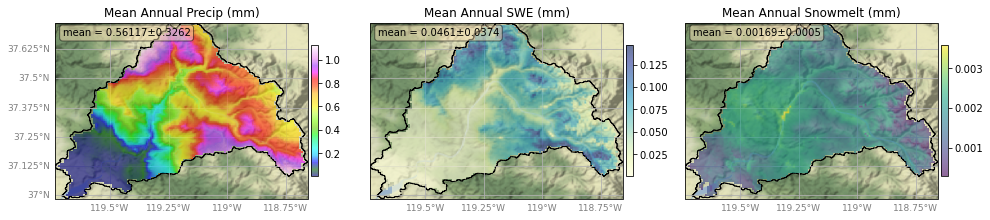

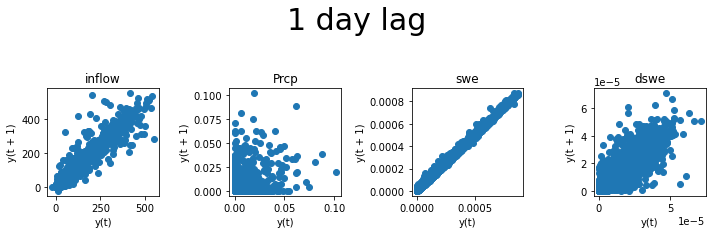

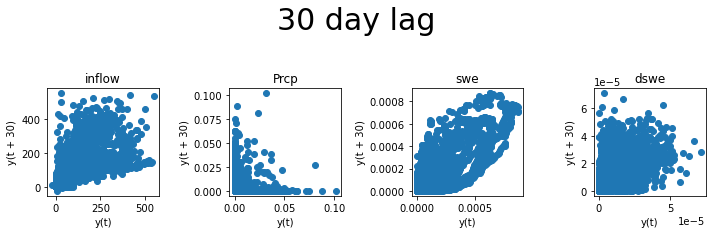

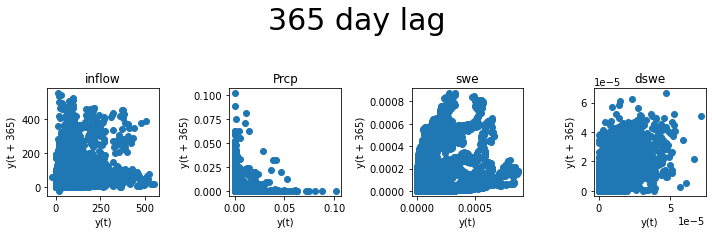

Testing q_cms for stationarity
ADF p = 2.0555338603514213e-06 < 0.01, Augmented Dicky Fuller null hypothesis rejected:
STATIONARY
ADF AIC lag = 30
KPSS p = 0.1 < 0.01, KPSS null hypothesis can't be rejected: - Stationary
STATIONARY
KPSS lag = 45
------------------------------------------------------------
Testing prcp for stationarity
ADF p = 9.414873083159083e-16 < 0.01, Augmented Dicky Fuller null hypothesis rejected:
STATIONARY
ADF AIC lag = 32
KPSS p = 0.1 < 0.01, KPSS null hypothesis can't be rejected: - Stationary
STATIONARY
KPSS lag = 30
------------------------------------------------------------
Testing swe for stationarity
ADF p = 2.322137663890251e-10 < 0.01, Augmented Dicky Fuller null hypothesis rejected:
STATIONARY
ADF AIC lag = 34
KPSS p = 0.1 < 0.01, KPSS null hypothesis can't be rejected: - Stationary
STATIONARY
KPSS lag = 45
------------------------------------------------------------
Testing dswe for stationarity
ADF p = 9.827427931109173e-08 < 0.01, Augmented Dicky 

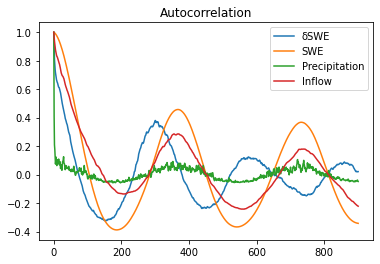

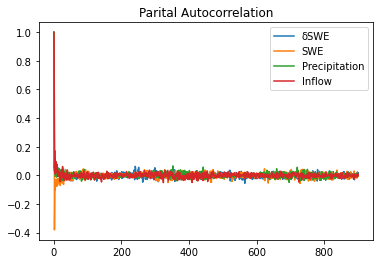

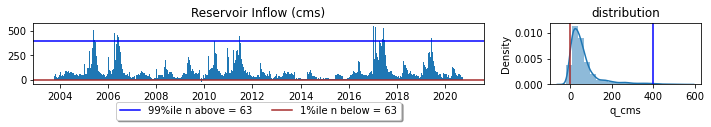

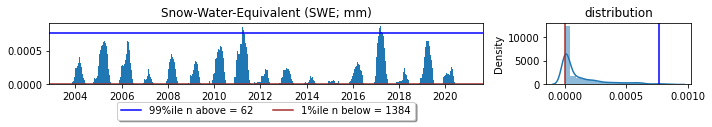

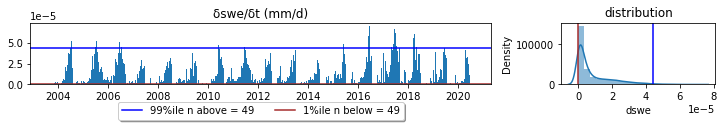

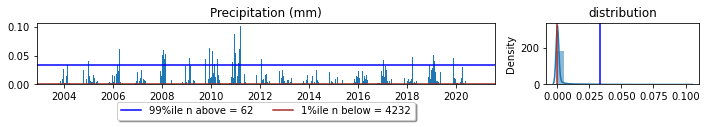

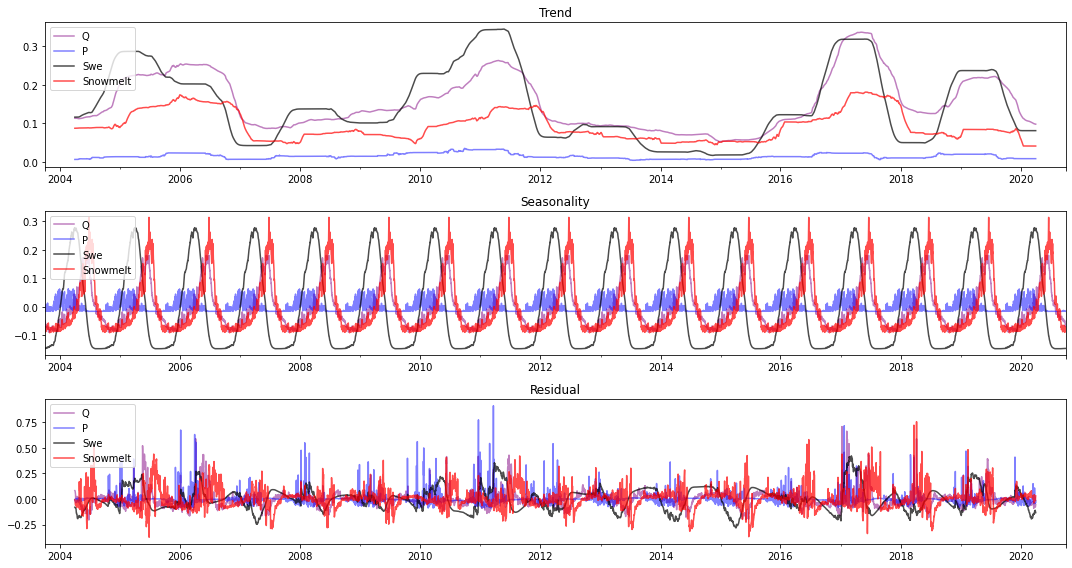

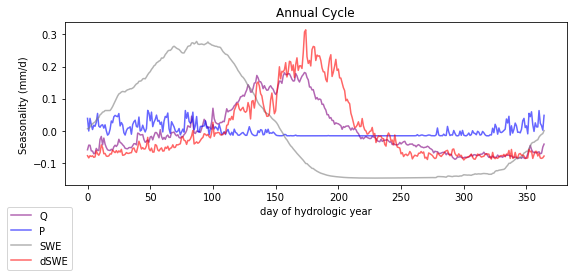

100%|██████████| 16/16 [00:00<00:00, 219310.01it/s]


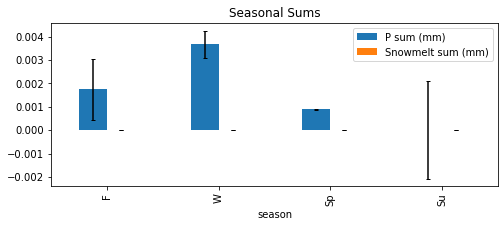

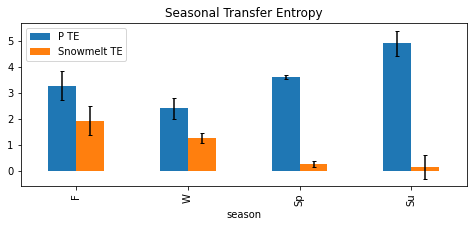

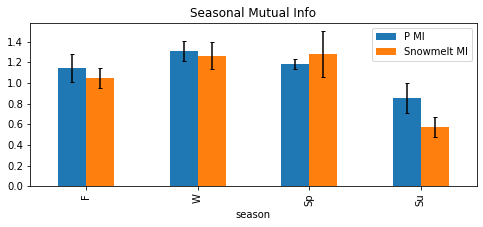

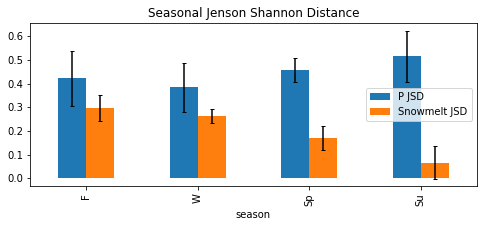

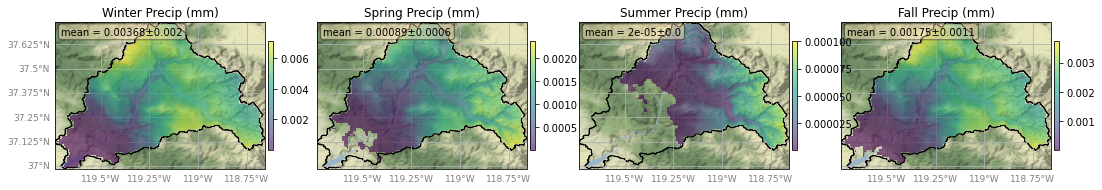

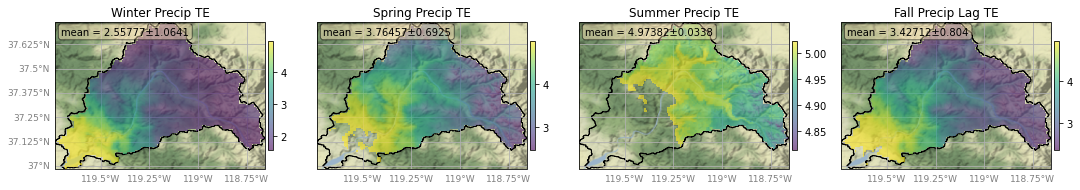

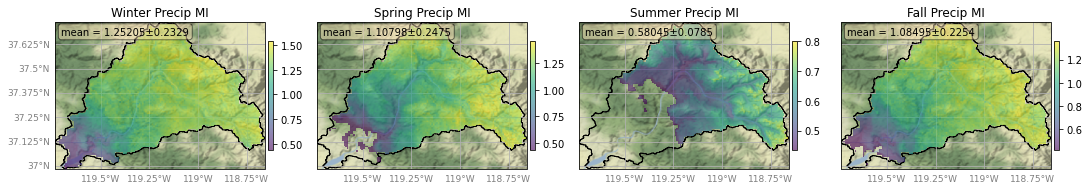

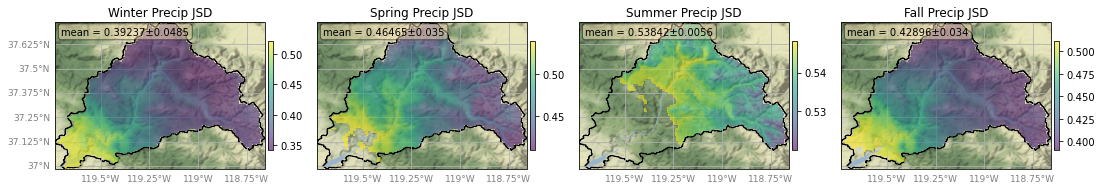

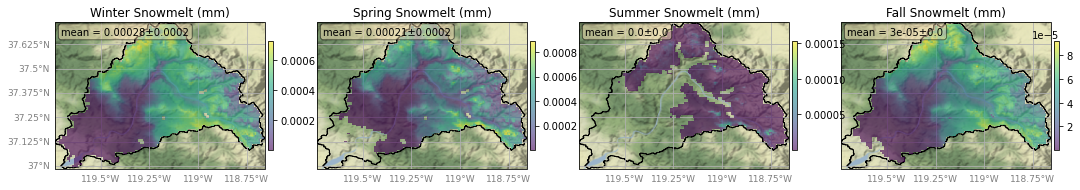

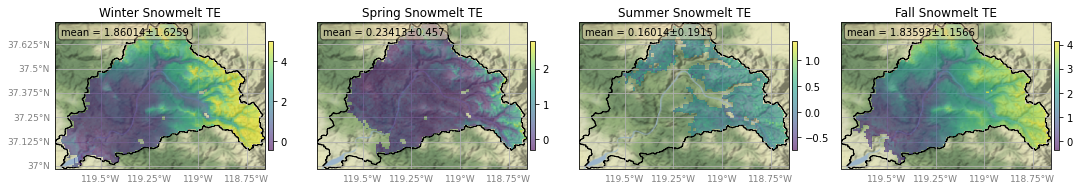

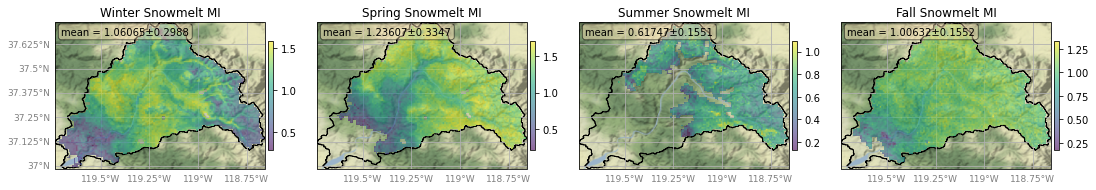

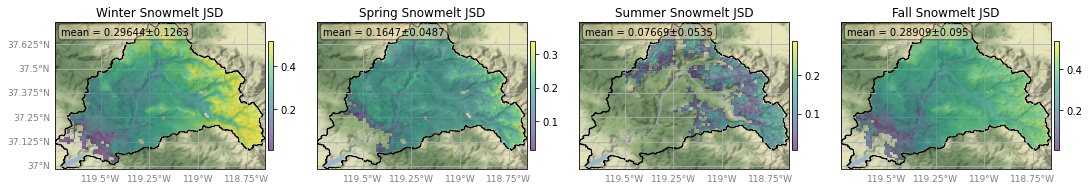

100%|██████████| 16/16 [00:00<00:00, 215784.13it/s]


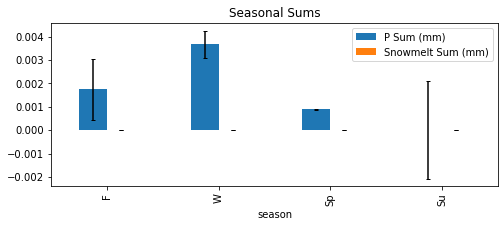

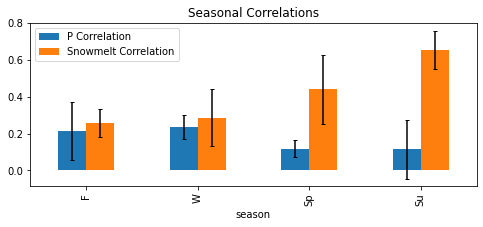

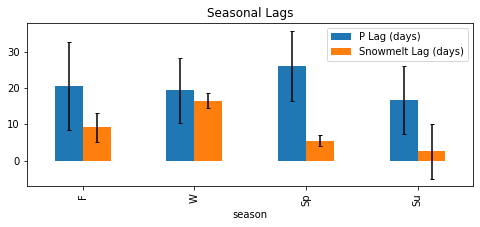

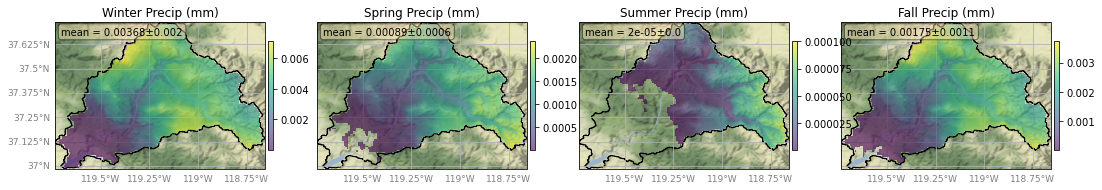

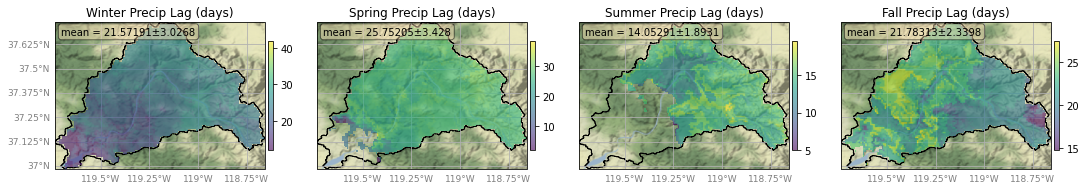

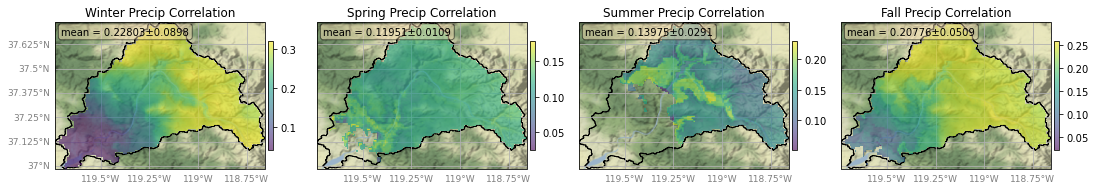

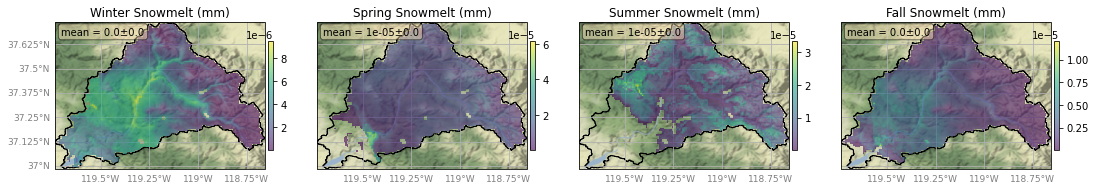

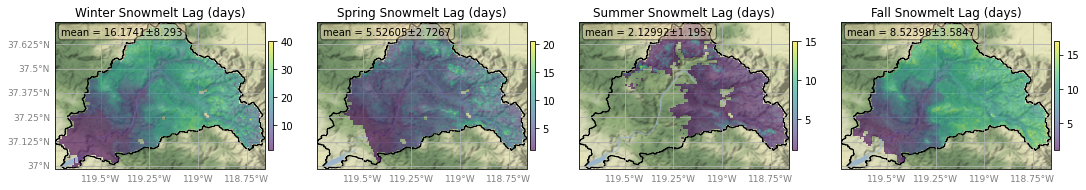

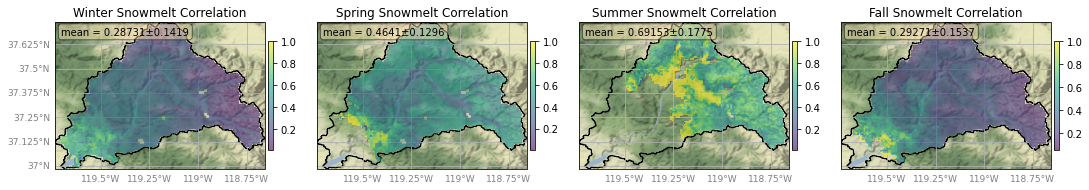

In [4]:
for idx, x in gdf[2:3].iterrows():
    print("****" * 15)
    # get catchment ID
    stn_id = x['stid']
    # Read catchment shapefile 
    catch_shp = "../shape/{}.shp".format(stn_id)
    # Needed for plotting
    shape_feature = ShapelyFeature(Reader(catch_shp).geometries(),
                            ccrs.PlateCarree(), edgecolor='black', facecolor = 'none')

    print("Processing catchment: {}".format( x['catch_name']))
    print("With reservoir terminus: {}".format(stn_id))

    # Set filepaths for hydro data 
    resfn = os.path.join('../data/res_inflow/{}_res.csv'.format(stn_id))
    swestack_fn = os.path.join('../data/swe/{}_swe.npy'.format(stn_id))
    meltstack_fn = os.path.join('../data/smlt/{}_smlt.npy'.format(stn_id))
    pstack_fn = os.path.join('../data/plqd/{}_plqd.npy'.format(stn_id))
    
    # Get the daily reservoir inflow
    if not os.path.exists(resfn):
        try:
            inflow = rs.col_to_dt(get_res_data(stn_id, startdate, enddate))
            inflow.to_csv(resfn)
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(resfn))
        if len(inflow) == 0:
            print("no data for {}".format(stn_id))
            continue

    # Get the SWE
    swestack = np.load(swestack_fn)
    swestack = swestack / 1000. # apply scaling factor 
    swevals = [swestack[:,:,t] for t in range(0, swestack.shape[2])]
    
    # Load dSWE
    dswe_unfilt = np.load(meltstack_fn)
    dswe = dswe_unfilt[:,:,-swestack.shape[2]:] # chop off the many trailing nans? 
    dswe = dswe / 100000. # apply scaling factor 
    dswevals = [dswe[:,:,t] for t in range(0, dswe.shape[2])]
    

    # Get the P data
    pstack_unfilt = np.load(pstack_fn)
    pstack = pstack_unfilt[:,:,-swestack.shape[2]:] # chop off the many trailing nans? 
    pstack = pstack / 10. # apply scaling factor 
    pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        
    # We can't compute things that need δsres for Merced, bear river, b/c it doesn't have data 
    if stn_id == "MCR" or stn_id == "CFW" or stn_id == "NHG":
        print("No Reservoir data for {}".format(stn_id))
        continue
    
    # chop off 1 col of NML because of strange data archiving ()
    if stn_id == "NML":
        continue
        
    ######## Basic EDA #########
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')
        
    # Get annual mean ims 
    pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]
    
    # Compute annual means
    annual_pmean = pmean # / len(dt_idx) * 365
    annual_swemean = swemean # / len(dt_idx) * 365
    annual_dswemean = dswemean # / len(dt_idx) * 365

    # Plot (mask swe pixels < 0.1mm/y)
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (16,8), subplot_kw={'projection': ccrs.PlateCarree()})

    plot_basemaps(annual_pmean, "Mean Annual Precip (mm)", cmap = 'gist_ncar', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(annual_swemean, "Mean Annual SWE (mm)", cmap = 'YlGnBu', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(annual_dswemean, "Mean Annual Snowmelt (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )

    plt.savefig("../figures/{}_means.png".format(stn_id))
    
    # Make df of watershed means
    shed_ts  = inflow.loc[dt_idx[0]:dt_idx[-1]]
    swevals = np.array([np.nanmean(x) for x in [swestack[:,:,t] for t in range(0, swestack.shape[2])]])
    dswevals = np.array([np.nanmean(x) for x in [dswe[:,:,t] for t in range(0, dswe.shape[2])]])
    pvals = np.array([np.nanmean(x) for x in [pstack[:,:,t] for t in range(0, pstack.shape[2])]])

    shed_ts['prcp'] = pvals
    shed_ts['swe'] = swevals
    shed_ts['dswe'] = dswevals # np.where(dswevals, 0, np.nan)

    # Make some lag plots
    make_lag_plots(shed_ts, lag = 1)
    make_lag_plots(shed_ts, lag = 30)
    make_lag_plots(shed_ts, lag = 365)
    
    # Hypothesis tests for stationarity 
    for col in shed_ts.columns:
        print("Testing {} for stationarity".format(col))

        # AD FUller test - null hypothesis is data is stationary 
        adfstat, adf_p, adf_lag, adf_nobs, adf_crit_vals, adf_icbest =  adfuller(shed_ts[col].dropna(), autolag = "AIC")
        if adf_p < 0.01:
            print("ADF p = {} < 0.01, Augmented Dicky Fuller null hypothesis rejected:".format(adf_p))
            print("STATIONARY")
            print("ADF AIC lag = {}".format(adf_lag))
        else:
            print("ADF p = {} > 0.01, Augmented Dicky Fuller null hypothesis NOT rejected:".format(adf_p))
            print("NON-Stationary")

        # KPSS test - null hypothesis is data is NOT stationary 
        kstat, k_p, k_lag, k_crit_vals = kpss(shed_ts[col].dropna(), nlags = 'auto')

        if k_p > 0.01:
            print("KPSS p = {} < 0.01, KPSS null hypothesis can't be rejected: - Stationary".format(k_p))
            print("STATIONARY")
            print("KPSS lag = {}".format(k_lag))
        else:
            print("KPSS p = {} < 0.01, KPSS null hypothesis rejected:".format(k_p))
            print("NON-Stationary")
        print("----"* 15)
    
    # Autocorrelation
    inflow_lag_acf = acf(shed_ts['q_cms'].dropna(), nlags=900)
    prcp_lag_acf = acf(shed_ts['prcp'].dropna(), nlags=900)
    swe_lag_acf = acf(shed_ts['swe'].dropna(), nlags=900)
    dswe_lag_acf = acf(shed_ts['dswe'].dropna(), nlags=900)

    plt.plot(dswe_lag_acf, label = 'δSWE')
    plt.plot(swe_lag_acf, label = 'SWE')
    plt.plot(prcp_lag_acf, label = 'Precipitation')
    plt.plot(inflow_lag_acf, label = 'Inflow')
    plt.legend()
    plt.title('Autocorrelation')
    plt.show()
    
    # Partial Autocorrelation
    inflow_lag_pacf = pacf(shed_ts['q_cms'].dropna(), nlags=900)
    prcp_lag_pacf = pacf(shed_ts['prcp'].dropna(), nlags=900)
    swe_lag_pacf = pacf(shed_ts['swe'].dropna(), nlags=900)
    dswe_lag_pacf = pacf(shed_ts['dswe'].dropna(), nlags=900)

    plt.plot(dswe_lag_pacf, label = 'δSWE')
    plt.plot(swe_lag_pacf, label = 'SWE')
    plt.plot(prcp_lag_pacf, label = 'Precipitation')
    plt.plot(inflow_lag_pacf, label = 'Inflow')
    plt.legend()
    plt.title('Parital Autocorrelation')
    plt.show()
    

    ######## More EDA #########    
    # Set the percentiles we use for the 'event' threshold 
    dswe_pct = 1
    prcp_pct = 99

    # Plot timeseries with percentiles
    plot_pct_ts(shed_ts['q_cms'], prcp_pct, dswe_pct, ts_var = 'Reservoir Inflow (cms)', dt_idx = dt_idx)
    plot_pct_ts(swevals, prcp_pct, dswe_pct, ts_var = 'Snow-Water-Equivalent (SWE; mm)', dt_idx = dt_idx)
    plot_pct_ts(shed_ts['dswe'], prcp_pct, dswe_pct, ts_var = 'δswe/δt (mm/d)', dt_idx = dt_idx)
    plot_pct_ts(pvals, prcp_pct, dswe_pct, ts_var = 'Precipitation (mm)', dt_idx = dt_idx)

    # Get into mm/d format and normalize
    shed_area_m2 = gp.read_file(catch_shp).to_crs('epsg:32611').area
    shed_ts['q_mm_d'] = normalize([x/shed_area_m2*86400*1000 for x in shed_ts['q_cms'].interpolate(how='linear').values ])
    shed_ts['prcp_mm_d'] = normalize([x/pstack.shape[0]/pstack.shape[1] for x in shed_ts['prcp'].values])
    shed_ts['swe_mm_d'] = normalize([x/swestack.shape[0]/swestack.shape[1] for x in shed_ts['swe'].values])
    shed_ts['dswe_mm_d'] = normalize([x/dswe.shape[0]/dswe.shape[1] for x in shed_ts['dswe'].values])
   
    # Seasonal decompose
    qstl = seasonal_decompose(shed_ts['q_mm_d'].interpolate(how = 'linear'),model = 'additive', period=365)
    pstl = seasonal_decompose(shed_ts['prcp_mm_d'].interpolate(how = 'linear'),model = 'additive', period=365)
    sstl = seasonal_decompose(shed_ts['swe_mm_d'].interpolate(how = 'linear'),model = 'additive', period=365)
    dstl = seasonal_decompose(shed_ts['dswe_mm_d'].fillna(0).interpolate(how = 'linear'),model = 'additive', period=365)

    # Seasonal Decomposition into seasonal, trend, anomaly components
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))

    # Trend
    qstl.trend.plot(ax=ax1, label = 'Q', color = 'purple', alpha = 0.5)
    pstl.trend.plot(ax=ax1, label = "P", color = 'blue', alpha = 0.5)
    sstl.trend.plot(ax=ax1, label = 'Swe', color = 'black', alpha = 0.7)
    dstl.trend.plot(ax=ax1, label = 'Snowmelt', color = 'red', alpha = 0.7)
    ax1.set_title("Trend")
    ax1.set_xlabel(None)

    # Seasonality
    qstl.seasonal.plot(ax=ax2, label = 'Q', color = 'purple', alpha = 0.5)
    pstl.seasonal.plot(ax=ax2, label = 'P', color = 'blue', alpha = 0.5)
    sstl.seasonal.plot(ax=ax2, label = 'Swe', color = 'black', alpha = 0.7)
    dstl.seasonal.plot(ax=ax2, label = 'Snowmelt', color = 'red', alpha = 0.7)
    ax2.set_title("Seasonality")
    ax2.set_xlabel(None)

    # Residual
    qstl.resid.plot(ax=ax3, label = 'Q', color = 'purple', alpha = 0.5)
    pstl.resid.plot(ax=ax3, label = 'P', color = 'blue', alpha = 0.5)
    sstl.resid.plot(ax=ax3, label = 'Swe', color = 'black', alpha = 0.7)
    dstl.resid.plot(ax=ax3, label = 'Snowmelt', color = 'red', alpha = 0.7)
    ax3.set_title("Residual")
    ax3.set_xlabel(None)

    [ax.legend(loc = 'upper left') for ax in [ax1, ax2, ax3]]

    plt.tight_layout()
    plt.show()
    
    # Plot annual cycle 
    tdf = pstl.seasonal
    mask = (tdf.index >= '2005-01-01') & (tdf.index <= '2005-12-31')

    plt.figure(figsize=(9,3))
    plt.plot(range(0,365), qstl.seasonal.loc[mask],alpha = 0.6, label = 'Q', color = 'purple')
    plt.plot(range(0,365), pstl.seasonal.loc[mask],alpha = 0.6, label = 'P', color = 'blue')
    plt.plot(range(0,365), sstl.seasonal.loc[mask],alpha = 0.6, label = 'SWE', color = 'gray')
    plt.plot(range(0,365), dstl.seasonal.loc[mask],alpha = 0.6, label = 'dSWE', color = 'red')
    plt.ylabel("Seasonality (mm/d)")
    
    plt.legend(loc = 'upper center', bbox_to_anchor = (-0.05, -0.1))
    plt.xlabel("day of hydrologic year")

    plt.title("Annual Cycle")
    plt.show()
    
    ########### Main Routine: Info Theory ###########
    outdir = "../rasters/response_IT"
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    # Assign seasons to months
    shed_ts['month'] = shed_ts.index.month
    seasons = {10:'F', 11:'F', 12:'F', 1:'W', 2:'W', 3:'W', 4:'Sp', 5:'Sp', 6:'Sp',7:'Su',8:'Su',9:'Su'}
    shed_ts['Season'] = shed_ts['month'].apply(lambda x: seasons[x])

    # Set time range
    years = range(2004,2020)
    
    # Define out dicts
    pdict_it = {} 
    sdict_it = {} 
    ddict_it = {} 

    # df for summary stats
    summary_df_it = []

    # Make nested dicts for each year 
    for y in years:
        pdict_it[y] = {}
        sdict_it[y] = {}
        ddict_it[y] = {}

    for y in tqdm(list(years)[:]):
        ydf = shed_ts[shed_ts.index.year == y]

        for season in ['W','Sp','Su','F'][:]:
            sdf = ydf[ydf.Season==season]

            # Get starting and ending indices of that season and subset data 
            t1 = sdf.index[0]
            t2 = sdf.index[-1]
            window = (dt_idx[dt_idx > t1]& dt_idx[dt_idx <= t2])

            # Copy the df for indices to filter the array
            ts = shed_ts.copy()
            ts['dt'] = ts.index
            ts.reset_index(inplace = True)
            start = ts[ts.dt == window[0]].index
            end = ts[ts.dt == window[-1]].index

            s, e = int(start.values), int(end.values)

            # sum the p, swe, dswe during that season
            psum = np.nanmean(pstack[:,:,s:e+1], axis =2)
            dsum = np.nanmean(dswe[:,:,s:e+1], axis =2)
            ssum = np.nanmean(swestack[:,:,s:e+1], axis =2)

            # Calc IT metrics 
            d_te, d_mi, d_jsd = calc_info(dswe[:,:,s:e+1], shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))
            s_te, s_mi, s_jsd = calc_info(swestack[:,:,s:e+1], shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))
            p_te, p_mi, p_jsd = calc_info(pstack[:,:,s:e+1], shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))

            # Mask vals with very little flux / state
            d_te, s_te, p_te = [np.ma.masked_where(y<0.0000000001,x) for x,y in zip([d_te, s_te, p_te],[dsum,ssum,psum])]
            d_mi, s_mi, p_mi = [np.ma.masked_where(y<0.0000000001,x) for x,y in zip([d_mi, s_mi, p_mi],[dsum,ssum,psum])]
            d_jsd, s_jsd, p_jsd = [np.ma.masked_where(y<0.0000000001,x) for x,y in zip([d_jsd, s_jsd, p_jsd],[dsum,ssum,psum])]
            
            # Mask zeros
            d_te, s_te, p_te = [np.ma.masked_where(y==np.nan,x) for x,y in zip([d_te, s_te, p_te],[dsum,ssum,psum])]
            d_mi, s_mi, p_mi = [np.ma.masked_where(y==np.nan,x) for x,y in zip([d_mi, s_mi, p_mi],[dsum,ssum,psum])]
            d_jsd, s_jsd, p_jsd = [np.ma.masked_where(y==np.nan,x) for x,y in zip([d_jsd, s_jsd, p_jsd],[dsum,ssum,psum])]
            
            # write to out dicts
            pdict_it[y][season] = [psum,p_te,p_mi,p_jsd]
            sdict_it[y][season] = [ssum,s_te,s_mi,s_jsd]
            ddict_it[y][season] = [ssum,d_te,d_mi,d_jsd]

            # make df for summary stats 
            df_dict_it = {"p_sum":np.nanmean(psum), "p_te":np.nanmean(p_te), "p_mi":np.nanmean(p_mi), "p_jsd": np.nanmean(p_jsd),
                        "s_sum":np.nanmean(ssum), "s_te":np.nanmean(s_te), "s_mi":np.nanmean(s_mi), "s_jsd": np.nanmean(s_jsd),
                        "d_sum":np.nanmean(dsum), "d_te":np.nanmean(d_te), "d_mi":np.nanmean(d_mi), "d_jsd": np.nanmean(d_jsd),}
            
            stats_dict_it = {k:[v] for k,v in df_dict_it.items()}
            stats_df_it = pd.DataFrame.from_dict(stats_dict_it)
            stats_df_it['year'] = y
            stats_df_it['season'] = season
            summary_df_it.append(stats_df_it)

    # Extract the results 
    psums, pte, pmi, pjsd = unpack_it_dict(pdict_it, years = years)
    ssums, ste, smi, sjsd = unpack_it_dict(sdict_it, years = years)
    dsums, dte, dmi, djsd = unpack_it_dict(ddict_it, years = years)
    
    # mask the zeros 
    for season in ['F', 'W', 'Sp', 'Su']:
        pte[season] = np.ma.masked_array(pte[season], mask=psums[season] == 0)
        pmi[season] = np.ma.masked_array(pmi[season], mask=psums[season] == 0)
        pjsd[season] = np.ma.masked_array(pjsd[season], mask=psums[season] == 0)

        ste[season] = np.ma.masked_array(ste[season], mask=ssums[season] == 0)
        smi[season] = np.ma.masked_array(smi[season], mask=ssums[season] == 0)
        sjsd[season] = np.ma.masked_array(sjsd[season], mask=ssums[season] == 0)

        dte[season] = np.ma.masked_array(dte[season], mask=dsums[season] == 0)
        dmi[season] = np.ma.masked_array(dmi[season], mask=dsums[season] == 0)
        djsd[season] = np.ma.masked_array(djsd[season], mask=dsums[season] == 0)

    # Barplots 
    itdf = pd.concat(summary_df_it)
    # Write out time series 
    itdf_out = itdf.reset_index()
    itdf_out.drop("index", axis = 1, inplace = True)
    itdf_out.to_csv("../data/time_ser_res/{}.csv".format(stn_id))

    # BarPlot sums by season
    pcdf = pd.DataFrame(itdf.groupby('season')['p_sum'].mean())
    dcdf = pd.DataFrame(itdf.groupby('season')['d_sum'].mean())
    scdf = pd.DataFrame(itdf.groupby('season')['s_sum'].mean())

    pcstd = itdf.groupby('season')['p_sum'].std()
    dcstd = itdf.groupby('season')['d_sum'].std()
    scstd = itdf.groupby('season')['s_sum'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P sum (mm)', 'Snowmelt sum (mm)']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]

    bardf.T.plot.bar(yerr = stds, capsize=2, figsize = (8,3))
    plt.title("Seasonal Sums")
    plt.show()

    # BarPlot TE by season
    pcdf = pd.DataFrame(itdf.groupby('season')['p_te'].mean())
    dcdf = pd.DataFrame(itdf.groupby('season')['d_te'].mean())
    scdf = pd.DataFrame(itdf.groupby('season')['s_te'].mean())

    pcstd = itdf.groupby('season')['p_te'].std()
    dcstd = itdf.groupby('season')['d_te'].std()
    scstd = itdf.groupby('season')['s_te'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P TE', 'Snowmelt TE']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]

    bardf.T.plot.bar(yerr = stds, capsize=2, figsize = (8,3))
    plt.title("Seasonal Transfer Entropy")
    plt.show()

    # BarPlot MI by season
    pcdf = pd.DataFrame(itdf.groupby('season')['p_mi'].mean())
    dcdf = pd.DataFrame(itdf.groupby('season')['d_mi'].mean())
    scdf = pd.DataFrame(itdf.groupby('season')['s_mi'].mean())

    pcstd = itdf.groupby('season')['p_mi'].std()
    dcstd = itdf.groupby('season')['d_mi'].std()
    scstd = itdf.groupby('season')['s_mi'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P MI', 'Snowmelt MI']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]

    bardf.T.plot.bar(yerr = stds, capsize=2, figsize = (8,3))
    plt.title("Seasonal Mutual Info")
    plt.show()
    
    # BarPlot JSD by season
    pcdf = pd.DataFrame(itdf.groupby('season')['p_jsd'].mean())
    dcdf = pd.DataFrame(itdf.groupby('season')['d_jsd'].mean())
    scdf = pd.DataFrame(itdf.groupby('season')['s_jsd'].mean())

    pcstd = itdf.groupby('season')['p_jsd'].std()
    dcstd = itdf.groupby('season')['d_jsd'].std()
    scstd = itdf.groupby('season')['s_jsd'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P JSD', 'Snowmelt JSD']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]

    bardf.T.plot.bar(yerr = stds, capsize=2, figsize = (8,3))
    plt.title("Seasonal Jenson Shannon Distance")
    plt.show()
    
    # Write out stats
    outdf_it = pd.concat([pcstd,dcstd,scstd,pcdf,dcdf,scdf], axis = 1).T
    if not os.path.exists("../data/seasonal_IT"):
        os.mkdir("../data/seasonal_IT")
        
    outdf_it.to_csv("../data/seasonal_IT/{}.csv".format(stn_id))

    # Plot maps

    # Precip

    # Plot the sums
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(psums['W'], "Winter Precip (mm)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(psums['Sp'], "Spring Precip (mm)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(psums['Su'], "Summer Precip (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(psums['F'], "Fall Precip (mm)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the TE
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(pte['W'], "Winter Precip TE", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(pte['Sp'], "Spring Precip TE", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(pte['Su'], "Summer Precip TE", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(pte['F'], "Fall Precip Lag TE", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the MI
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(pmi['W'], "Winter Precip MI", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(pmi['Sp'], "Spring Precip MI", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(pmi['Su'], "Summer Precip MI", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(pmi['F'], "Fall Precip MI", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()
    
    # Plot the JSD
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(pjsd['W'], "Winter Precip JSD", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(pjsd['Sp'], "Spring Precip JSD", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(pjsd['Su'], "Summer Precip JSD", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(pjsd['F'], "Fall Precip JSD", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()


    # dswe

    # Plot the sums
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(dsums['W'], "Winter Snowmelt (mm)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(dsums['Sp'], "Spring Snowmelt (mm)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(dsums['Su'], "Summer Snowmelt (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(dsums['F'], "Fall Snowmelt (mm)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the TE
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(dte['W'], "Winter Snowmelt TE", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(dte['Sp'], "Spring Snowmelt TE", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(dte['Su'], "Summer Snowmelt TE", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(dte['F'], "Fall Snowmelt TE", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the MI
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(dmi['W'], "Winter Snowmelt MI", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(dmi['Sp'], "Spring Snowmelt MI", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(dmi['Su'], "Summer Snowmelt MI", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(dmi['F'], "Fall Snowmelt MI", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()
    
    # Plot the JSD
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(djsd['W'], "Winter Snowmelt JSD", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(djsd['Sp'], "Spring Snowmelt JSD", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(djsd['Su'], "Summer Snowmelt JSD", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(djsd['F'], "Fall Snowmelt JSD", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

        
    ########### Main Routine: cross correlation ###########
    
    # Setup out dirs
    outdir = "../rasters/response_plqd_smlt"
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    # Assign seasons to months
    shed_ts['month'] = shed_ts.index.month
    seasons = {10:'F', 11:'F', 12:'F', 1:'W', 2:'W', 3:'W', 4:'Sp', 5:'Sp', 6:'Sp',7:'Su',8:'Su',9:'Su'}
    shed_ts['Season'] = shed_ts['month'].apply(lambda x: seasons[x])

    # Set time range

    # Define out dicts
    pdict = {} 
    sdict = {} 
    ddict = {} 

    # df for summary stats
    summary_df = []

    # Make nested dicts for each year 
    for y in years:
        pdict[y] = {}
        sdict[y] = {}
        ddict[y] = {}

    for y in tqdm(list(years)[:]):
        ydf = shed_ts[shed_ts.index.year == y]

        for season in ['W','Sp','Su','F'][:]:
            sdf = ydf[ydf.Season==season]

            # Get starting and ending indices of that season and subset data 
            t1 = sdf.index[0]
            t2 = sdf.index[-1]
            window = (dt_idx[dt_idx > t1]& dt_idx[dt_idx <= t2])

            # Copy the df for indices to filter the array
            ts = shed_ts.copy()
            ts['dt'] = ts.index
            ts.reset_index(inplace = True)
            start = ts[ts.dt == window[0]].index
            end = ts[ts.dt == window[-1]].index

            s, e = int(start.values), int(end.values)

            # sum the p, swe, dswe during that season
            psum = np.nanmean(pstack[:,:,s:e+1], axis =2)
            dsum = np.nanmean(dswe[:,:,s:e+1], axis =2)
            ssum = np.nanmean(swestack[:,:,s:e+1], axis =2)

            # Calc corrs

            dlag, dcorr = calc_xcorr_fft(dswe[:,:,s:e+1], shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))
            slag, scorr = calc_xcorr_fft(swestack[:,:,s:e+1], shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))
            plag, pcorr = calc_xcorr_fft(pstack[:,:,s:e+1], shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))

            dcorr,scorr, pcorr = [abs(cor) for cor in [dcorr, scorr, pcorr]]

            # Mask lag vals with very little flux / state
            dlag, slag, plag = [np.ma.masked_where(y>0.0000000001,x) for x,y in zip([dlag,slag,plag],[dsum,ssum,psum])]
            dlag, slag, plag = [mask_zero_corrs(x,y) for x,y in zip([dlag,slag,plag],[dcorr,scorr,pcorr])]
            dcorr, scorr, pcorr = [mask_zero_corrs(x,y) for x,y in zip([dcorr, scorr, pcorr],[dcorr,scorr,pcorr])]

            # write to out dicts
            pdict[y][season] = [psum,plag,pcorr]
            sdict[y][season] = [ssum,slag,scorr]
            ddict[y][season] = [dsum,dlag,dcorr]

            # make df for summary stats 
            df_dict = {"p_sum":np.nanmean(psum), "p_lag":np.nanmean(plag), "p_corr":np.nanmean(pcorr), 
                        "s_sum":np.nanmean(ssum), "s_lag":np.nanmean(slag), "s_corr":np.nanmean(scorr),
                        "d_sum":np.nanmean(dsum), "d_lag":np.nanmean(dlag), "d_corr":np.nanmean(dcorr)}
            stats_dict = {k:[v] for k,v in df_dict.items()}
            stats_df = pd.DataFrame.from_dict(stats_dict)
            stats_df['year'] = y
            stats_df['season'] = season
            summary_df.append(stats_df)

    # Extract the results 
    psums, plags, pcorrs = unpack_var_dict(pdict, years = years)
    ssums, slags, scorrs = unpack_var_dict(sdict, years = years)
    dsums, dlags, dcorrs = unpack_var_dict(ddict, years = years)

    # Barplots 
    tdf = pd.concat(summary_df)
    # Write out time series 
    tdf_out = tdf.reset_index()
    tdf_out.drop("index", axis = 1, inplace = True)
    tdf_out.to_csv("../data/time_ser_res/{}.csv".format(stn_id))

    # BarPlot sums by season
    pcdf = pd.DataFrame(tdf.groupby('season')['p_sum'].mean())
    dcdf = pd.DataFrame(tdf.groupby('season')['d_sum'].mean())
    scdf = pd.DataFrame(tdf.groupby('season')['s_sum'].mean())

    pcstd = tdf.groupby('season')['p_sum'].std()
    dcstd = tdf.groupby('season')['d_sum'].std()
    scstd = tdf.groupby('season')['s_sum'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P Sum (mm)', 'Snowmelt Sum (mm)']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]

    bardf.T.plot.bar(yerr = stds, capsize=2, figsize = (8,3))
    plt.title("Seasonal Sums")
    plt.show()

    # BarPlot corrs by season
    pcdf = pd.DataFrame(tdf.groupby('season')['p_corr'].mean())
    dcdf = pd.DataFrame(tdf.groupby('season')['d_corr'].mean())
    scdf = pd.DataFrame(tdf.groupby('season')['s_corr'].mean())

    pcstd = tdf.groupby('season')['p_corr'].std()
    dcstd = tdf.groupby('season')['d_corr'].std()
    scstd = tdf.groupby('season')['s_corr'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P Correlation', 'Snowmelt Correlation']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]

    bardf.T.plot.bar(yerr = stds, capsize=2, figsize = (8,3))
    plt.title("Seasonal Correlations")
    plt.show()

    # BarPlot lags by season
    pcdf = pd.DataFrame(tdf.groupby('season')['p_lag'].mean())
    dcdf = pd.DataFrame(tdf.groupby('season')['d_lag'].mean())
    scdf = pd.DataFrame(tdf.groupby('season')['s_lag'].mean())

    pcstd = tdf.groupby('season')['p_lag'].std()
    dcstd = tdf.groupby('season')['d_lag'].std()
    scstd = tdf.groupby('season')['s_lag'].std()
    stds = [list(pcstd.values),list(dcstd.values)]

    stddf = pd.concat([pcstd,dcstd,scstd], axis = 1).T
    bardf = pd.concat([pcdf,dcdf], axis = 1)
    bardf.columns = ['P Lag (days)', 'Snowmelt Lag (days)']
    bardf = bardf.T
    bardf = bardf[['F', 'W','Sp','Su']]
    
    bardf.T.plot.bar(yerr = stds, capsize=2,figsize = (8,3))
    plt.title("Seasonal Lags")
    plt.show()
    
    # Write out stats
    outdf = pd.concat([pcstd,dcstd,scstd,pcdf,dcdf,scdf], axis = 1).T
    if not os.path.exists("../data/seasonal"):
        os.mkdir("../data/seasonal")
        
    outdf.to_csv("../data/seasonal/{}.csv".format(stn_id))

    # Plot maps

    # Precip

    # Plot the sums
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(psums['W'], "Winter Precip (mm)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(psums['Sp'], "Spring Precip (mm)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(psums['Su'], "Summer Precip (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(psums['F'], "Fall Precip (mm)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the lags
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(plags['W'], "Winter Precip Lag (days)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(plags['Sp'], "Spring Precip Lag (days)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(plags['Su'], "Summer Precip Lag (days)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(plags['F'], "Fall Precip Lag (days)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the cors
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(pcorrs['W'], "Winter Precip Correlation", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(pcorrs['Sp'], "Spring Precip Correlation", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(pcorrs['Su'], "Summer Precip Correlation", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(pcorrs['F'], "Fall Precip Correlation", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # dswe

    # Plot the sums
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(dsums['W'], "Winter Snowmelt (mm)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(dsums['Sp'], "Spring Snowmelt (mm)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(dsums['Su'], "Summer Snowmelt (mm)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(dsums['F'], "Fall Snowmelt (mm)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the lags
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(dlags['W'], "Winter Snowmelt Lag (days)", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(dlags['Sp'], "Spring Snowmelt Lag (days)", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(dlags['Su'], "Summer Snowmelt Lag (days)", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(dlags['F'], "Fall Snowmelt Lag (days)", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()

    # Plot the cors
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_basemaps(dcorrs['W'], "Winter Snowmelt Correlation", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(dcorrs['Sp'], "Spring Snowmelt Correlation", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True)
    plot_basemaps(dcorrs['Su'], "Summer Snowmelt Correlation", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True )
    plot_basemaps(dcorrs['F'], "Fall Snowmelt Correlation", cmap = 'viridis', ax = axes[3], latlabels = False, lonlabels = True )
    plt.show()
